In [ ]:
!pip install keras

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
pd.options.mode.chained_assignment = None 
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, accuracy_score

In [2]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten
from keras.layers.core import Dense, Activation, Flatten, Dropout
from keras.optimizers import Adam
from keras.layers import Conv1D, Conv2D, MaxPooling2D
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
%cd /content/gdrive/My Drive/kaggle

/content/gdrive/My Drive/kaggle


In [5]:
df_prices = pd.read_csv('prices.csv')
df_prices.head()


,date,symbol,open,close,low,high,volume
0,2016-01-05 00:00:00,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
1,2016-01-06 00:00:00,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2,2016-01-07 00:00:00,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
3,2016-01-08 00:00:00,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
4,2016-01-11 00:00:00,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


In [6]:
data = df_prices[(df_prices['symbol']=='GOOGL')] #get the data for google stock prices

In [7]:
data.reset_index(drop=True, inplace=True) # reset the index of the extracted data
data.head()

,date,symbol,open,close,low,high,volume
0,2010-01-04,GOOGL,626.950006,626.750011,624.240011,629.510005,3908400.0
1,2010-01-05,GOOGL,627.180001,623.990017,621.540016,627.839984,6003300.0
2,2010-01-06,GOOGL,625.860033,608.260035,606.360021,625.860033,7949400.0
3,2010-01-07,GOOGL,609.400008,594.100015,592.649990,609.999993,12815700.0
4,2010-01-08,GOOGL,592.000005,602.020005,589.110015,603.250036,9439100.0


In [8]:
data.describe()

,open,close,low,high,volume
count,1762.000000,1762.000000,1762.000000,1762.000000,1.762000e+03
mean,675.864352,675.583348,669.769148,681.287468,4.096043e+06
std,161.953370,161.869288,161.099882,162.608176,2.884423e+06
min,438.310006,436.069999,433.629998,442.280000,5.206000e+05
25%,557.057500,555.770031,551.015007,560.937500,2.004075e+06
50%,617.060003,616.500017,611.999990,620.820034,3.670550e+06
75%,764.227509,762.774979,757.354995,769.319992,5.171750e+06
max,1226.800064,1220.169982,1218.600020,1228.880013,2.961990e+07


Text(0.5, 1.0, 'Google Stock value changes since 2010')

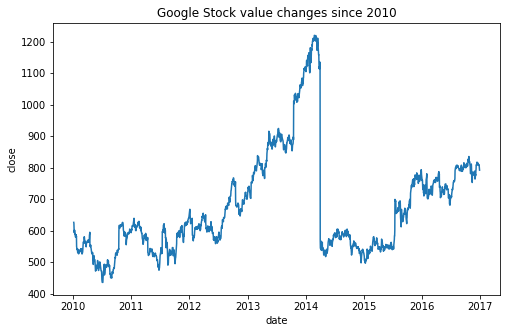

In [9]:
data.date =pd.to_datetime(data.date)
fig=plt.figure(figsize=(8,5))
ax=sns.lineplot(data=data, x='date',y='close');
# for s in ['left','right','top','bottom']:
#     ax.spines[s].set_visible(False)

plt.title("Google Stock value changes since 2010", size=12)


In [10]:
# remove non-numeric features from the dataset
df = data.drop(columns=['symbol', 'date']) 

In [11]:
#convert the prices to be in range of 0,1
"""feature_range=(0,1)"""
scaler = MinMaxScaler(feature_range=(0,1)) 
df = scaler.fit_transform(df) 
X = df # array of feature vectors [open,close,low,high,volume]
y = df[:,1] #target value for the closing prices (array of close values)

#split the dataset in training, test and validation sets
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,y, test_size=0.2, shuffle=False) # split both X and Y into individual train and test sets



In [12]:
#convert data into timeseries data for 2 dimensional image
def to_seq(size, data):
    x = []
    for i in range(len(data)-size-1):
        seq = data[i:(i+size)] #seq contains the suceeding size feature vectors 
        seq = [[x] for x in seq]  
        x.append(seq) 
    return np.array(x)

# shifts values by size 
def to_seq_Y(size, data):
  x = []
  for i in range(len(data)-size-1):
    seq = data[i+size]
    x.append(seq)
  return np.array(x)

seq_size = 10
x_train = to_seq(seq_size, X_train) #4d array 
x_test = to_seq(seq_size, X_test) #4d array 

y_train = to_seq_Y(seq_size, Y_train) 
y_test = to_seq_Y(seq_size, Y_test)

In [13]:
x_train = np.reshape(x_train,(x_train.shape[0], x_train.shape[2], x_train.shape[1],x_train.shape[3]))
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[2],x_test.shape[1],x_test.shape[3]))

print("Shape of x_train: {}".format(x_train.shape))
print("Shape of x_test: {}".format(x_test.shape))
print("Shape of y_train: {}".format(y_train.shape))
print("Shape of y_test: {}".format(y_test.shape))

Shape of x_train: (1398, 1, 10, 5)
Shape of x_test: (342, 1, 10, 5)
Shape of y_train: (1398,)
Shape of y_test: (342,)


In [14]:
model = Sequential()
model.add(Conv2D(8, kernel_size = (3, 3), strides = (1, 1),  padding = 'same', 
               activation = 'relu', input_shape = (x_train.shape[1],x_train.shape[2],x_train.shape[3])))
model.add(MaxPooling2D(pool_size = (1,2)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64, activation = 'relu')) #changing the dimensions of the vector and apply activation function
model.add(Dropout(0.5)) #regularize data
model.add(Dense(1, activation ='sigmoid')) # use the sigmoid activation function since we have a binary outcome

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 1, 10, 8)          368       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 1, 5, 8)           0         
_________________________________________________________________
flatten (Flatten)            (None, 40)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                2624      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 3,057
Trainable params: 3,057
Non-trainable params: 0
______________________________________________________

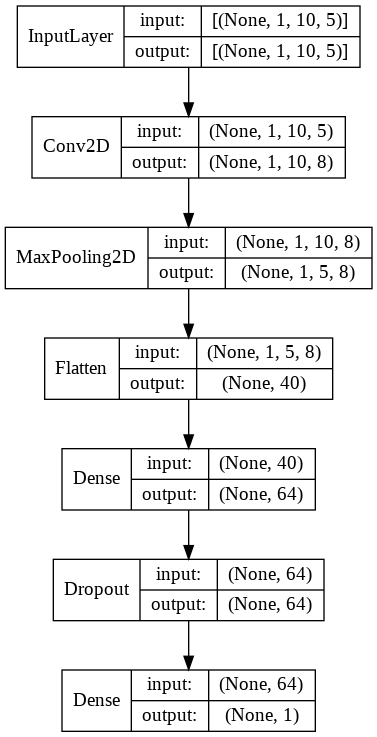

In [15]:
from tensorflow.keras.utils import model_to_dot, plot_model

plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=False)


In [16]:
from keras import optimizers
adam = optimizers.Adam(lr = 0.01)

model.compile(loss='mean_squared_error', optimizer=adam)

In [17]:
history = model.fit(x_train,y_train,validation_split=0.2,batch_size = 64,epochs = 100)

Epoch 1/100
18/18 [==============================] - 1s 37ms/step - loss: 0.0551 - val_loss: 0.0021
Epoch 2/100
18/18 [==============================] - 0s 4ms/step - loss: 0.0087 - val_loss: 0.0056
Epoch 3/100
18/18 [==============================] - 0s 4ms/step - loss: 0.0065 - val_loss: 0.0037
Epoch 4/100
18/18 [==============================] - 0s 4ms/step - loss: 0.0057 - val_loss: 0.0022
Epoch 5/100
18/18 [==============================] - 0s 4ms/step - loss: 0.0050 - val_loss: 0.0013
Epoch 6/100
18/18 [==============================] - 0s 4ms/step - loss: 0.0041 - val_loss: 5.1345e-04
Epoch 7/100
18/18 [==============================] - 0s 4ms/step - loss: 0.0036 - val_loss: 4.1712e-04
Epoch 8/100
18/18 [==============================] - 0s 4ms/step - loss: 0.0029 - val_loss: 4.9662e-04
Epoch 9/100
18/18 [==============================] - 0s 5ms/step - loss: 0.0020 - val_loss: 4.6527e-04
Epoch 10/100
18/18 [==============================] - 0s 5ms/step - loss: 0.0032 - val_loss:

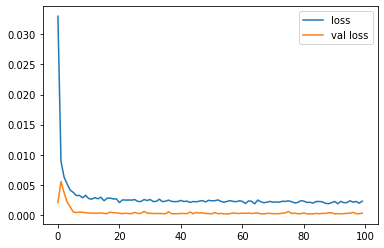

In [18]:
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val loss')
plt.legend()


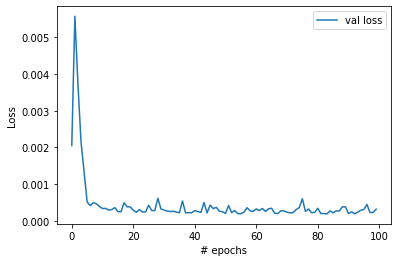

In [19]:
plt.plot(history.history['val_loss'], label = 'val loss')
plt.xlabel("# epochs")
plt.ylabel("Loss")
plt.legend()

In [20]:
pred = model.predict(x_test)
print(pred.shape)

(342, 1)


In [21]:
score = np.sqrt(metrics.mean_squared_error(y_test, pred))
print("RMSE Score: {}".format(score))

RMSE Score: 0.015741472998654336


In [22]:
pred_df = pd.DataFrame({'Actual': y_test, 'Predicted': pred.flatten()})
pred_df

,Actual,Predicted
0,0.232164,0.291114
1,0.224971,0.222833
2,0.285257,0.243495
3,0.295740,0.268922
4,0.285193,0.292478
...,...,...
337,0.476483,0.468997
338,0.474085,0.465118
339,0.476801,0.462982
340,0.469966,0.464997


In [23]:
from sklearn.metrics import r2_score
print("Accuracy score of the predictions: {0}".format(r2_score(y_test, pred)))

Accuracy score of the predictions: 0.9345383062586532


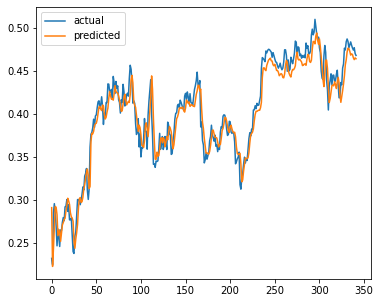

In [24]:
plt.figure(figsize=(6,5))

plt.plot(y_test, label = 'actual')
plt.plot(pred,   label = 'predicted')
plt.legend()
plt.show()
